In [3]:
#!/usr/bin/env python
#-*- coding: utf-8 -*-

import sc2reader, time
from sc2reader import events # Use the LOTV branch for sc2reader!
from multiprocessing import Pool as ThreadPool


global params
# arguments to be shared for all threads.
params = {}
params["dir"] = "./replay-data/"
params["nbac"] = 300
params["nbsec"] = 30
params["tw"] = 5
params["out"] = "replay-traces.txt"


# Parse a single replay
def parse_replay(filename):
    global params
    print("Parsing: " + str(filename))
    try:
        result = ""
        replay = sc2reader.load_replay(filename, load_level=4, debug=True)
        # @TODO: Do we really get players only? No observator, refeerees, ...?
        players = [t.players for t in replay.teams]
        players = [y for x in players for y in x]
        for i in range(1, len(players) + 1):
            player_trace = players[i - 1].url
            player_trace += "," + players[i - 1].play_race
            last = 0
            action_count = 0
            for event in replay.player[i].events:
                if event.second > params["nbsec"]: break
                if action_count > params["nbac"]: break
                if event.second - last >= params["tw"]:
                    while event.second - last >= params["tw"]:
                        last += params["tw"]
                        player_trace += ",t" + str(last)
                if isinstance(event, sc2reader.events.game.SelectionEvent):
                    elements = [o.name for o in event.objects]
                    if "Nexus" in elements or "Hatchery" in elements or "Command Center" in elements:
                        player_trace += ",Base"
                        action_count += 1
                    if "MineralField" in elements and len(elements) == 1:
                        player_trace += ",SingleMineral"
                        action_count += 1
                    player_trace += ",s"
                elif isinstance(event, sc2reader.events.game.ControlGroupEvent):
                    player_trace += ",hotkey" + str(event.hotkey) + str(event.update_type)
                    action_count += 1
            result += player_trace+"\n"
        return result
    except:
        print("Unable to parse this replay:" + filename)
        return ""


def replays2traces(dir, nbac, nbsec, tw, out):
    global params
    params["dir"] = dir
    params["nbac"] = nbac
    params["nbsec"] = nbsec
    params["tw"] = tw
    params["out"] = out
    replays_to_parse = sc2reader.utils.get_files(dir)
    pool = ThreadPool(4)
    results = pool.map(parse_replay, replays_to_parse)
    pool.close()
    pool.join()
    with open(out, "w") as text_file:
        for r in results:
            if len(r) > 0:
                text_file.write(r)



In [4]:
from collections import Counter

def traces2features(inputfile, outputfile, maxsec):
    features = []
    races = []
    urls = []
    with open(inputfile, "r") as traces:
        for trace in traces:
            trace = trace[:len(trace)-1]  # remove the '\n'
            actions = trace.split(",")
            urls += [actions[0]]
            races += [actions[1]]
            if "t"+str(maxsec) in actions:
                actions = actions[:actions.index("t"+str(maxsec))]
            actions = actions[2:]
            actions = [a for a in actions if not a[0] == "t"]
            dico = Counter(actions)
            features += [dico]
    features_name_list = sorted(set([action for f in features for action in f.keys()]))

    with open(outputfile, "w") as text_file:
        text_file.write(",".join(features_name_list) + ",race,battleneturl\n" )
        index = 0
        for f in features:
            text_file.write(",".join([str(f[k]) for k in features_name_list]) + "," + races[index] + "," + urls[index] + '\n')
            index += 1


In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import tree
from collections import Counter


def encode_target(df, target_column):
    """Add column to df with integers for the target.
    Args
    ----
    df -- pandas DataFrame.
    target_column -- column to map to int, producing
                     new Target column.
    Returns
    -------
    df_mod -- modified DataFrame.
    targets -- list of target names.
    """
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod[target_column] = df_mod[target_column].replace(map_to_int)
    return(df_mod, targets)


def remove_unpopulated_classes(_df, target_column, threshold):
    """
    Removes any row of the df for which the label in target_column appears less
    than threshold times in the whole frame (not enough populated classes)
    :param df: The dataframe to filter
    :param target_column: The target column with labels
    :param threshold: the number of appearances a label must respect
    :return: The filtered dataframe
    """
    count = Counter(_df[target_column])
    valid = [k for k in count.keys() if count[k] >= threshold]
    _df = _df[_df[target_column].isin(valid)]
    return _df


def learn(inputfile, minlabels):

    df = pd.read_csv(inputfile)
    df2, _ = encode_target(df, "battleneturl")
    df3, _ = encode_target(df2, "race")
    df4 = remove_unpopulated_classes(df3, "battleneturl", minlabels)
    train_data = df4.values
    target = train_data[:, -1:].ravel()
    features = train_data[:, :-1]
    print("Data read.")

    # Cross validation
    model = RandomForestClassifier(max_features=None)
    print(model.get_params())
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(features,target, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(score)

    # 5 Cross validation
    #model = RandomForestClassifier(max_features=None)
    #print(model.get_params())
    #scores = cross_validation.cross_val_score(model, features, target, cv=5, scoring='accuracy')
    #print("accuracy: ", scores)
    #scores = cross_validation.cross_val_score(model, features, target, cv=5, scoring='precision_micro')
    #print("precision:", scores)

    return score


In [10]:
import time

from parser import replays2traces
from features import traces2features
from models import learn
import matplotlib.pyplot as plt

import numpy as np
import numpy.random

replays2traces("replay-data/Whitera_replay_pack/", 1000, 100, 5, "replay-traces.txt")
maxseconds = [i for i in range(0, 101, 20)]
minlabels = [j for j in range(0, 101, 20)]
scores = []

for i in maxseconds:
    traces2features("replay-traces.txt", "features-train.txt", i)
    row = []
    for j in minlabels:
        score = learn("features-train.txt", j)
        row += [score]
    scores.append(row)

print(scores)

    #plt.clf()
    #plt.xlabel('Minimum number of games per player')
    #plt.ylabel('Classifier score ')
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 100])
    #plt.title('Classifier score w.r.t. label count')
    #plt.legend(loc="lower left")
    #plt.plot(minlabels, scores, '-')
    #plt.show()

   

Parsing: replay-data/Whitera_replay_pack/2012-07-30 - WhiteRa (P) vs DaNa (Z) - ESL Cloud Kingdom.SC2Replay
Parsing: replay-data/Whitera_replay_pack/2012-08-11 - WhiteRa (P) vs nSgZlaTaN (Z) - Daybreak LE.SC2Replay
Parsing: replay-data/Whitera_replay_pack/2012-09-06 - WhiteRa (P) vs aLtnirvAnA (T) - Fractured Glacier.SC2Replay
Parsing: replay-data/Whitera_replay_pack/2012-08-11 - WhiteRa (P) vs AlaStOr (Z) - Daybreak LE.SC2Replay
Parsing: replay-data/Whitera_replay_pack/2012-09-06 - WhiteRa (P) vs aTnDelphi (Z) - Howling Peak.SC2Replay
Parsing: replay-data/Whitera_replay_pack/2012-08-11 - WhiteRa (P) vs Protosser (Z) - Antiga Shipyard.SC2Replay
Parsing: replay-data/Whitera_replay_pack/2012-08-11 - WhiteRa (P) vs aTnClouD (T) - Entombed Valley.SC2Replay
Parsing: replay-data/Whitera_replay_pack/2012-08-11 - WhiteRa (P) vs SjoW (T) - Cloud Kingdom LE.SC2Replay
Parsing: replay-data/Whitera_replay_pack/2012-08-11 - WhiteRa (P) vs aTnDelphi (Z) - Entombed Valley.SC2Replay
Parsing: replay-dat

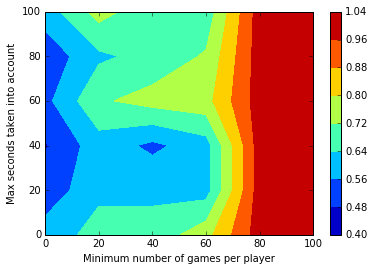

In [13]:
%matplotlib inline
plt.contourf(minlabels, maxseconds, scores) # Dim: i, j, ixj
plt.colorbar()
plt.xlabel('Minimum number of games per player')
plt.ylabel('Max seconds taken into account')
plt.show()